# 随机梯度下降
:label:`sec_sgd`

在前面的章节中，我们在训练过程中一直使用随机梯度下降，但没有解释它为什么有效。
为了阐明这一点，
我们在 :numref:`sec_gd` 中描述了梯度下降的基本原理。
在本节中，我们将更详细地讨论*随机梯度下降*。

In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

## 随机梯度更新

在深度学习中，目标函数通常是训练数据集中每个样本的损失函数的平均值。
给定一个包含 $n$ 个样本的训练数据集，
我们假设 $f_i(\mathbf{x})$ 是关于索引为 $i$ 的训练样本的损失函数，
其中 $\mathbf{x}$ 是参数向量。
然后我们得到目标函数

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

目标函数在 $\mathbf{x}$ 处的梯度计算为

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

如果使用梯度下降法，每次独立变量迭代的计算成本是 $\mathcal{O}(n)$，这与 $n$ 成线性增长。因此，当训练数据集较大时，每次迭代的梯度下降成本将更高。

随机梯度下降（SGD）减少了每次迭代的计算成本。在随机梯度下降的每次迭代中，我们从 $\{1,\ldots, n\}$ 中均匀随机采样一个索引 $i$，并计算梯度 $\nabla f_i(\mathbf{x})$ 来更新 $\mathbf{x}$：

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

其中 $\eta$ 是学习率。我们可以看到，每次迭代的计算成本从梯度下降的 $\mathcal{O}(n)$ 降到了常数 $\mathcal{O}(1)$。此外，我们想强调的是，随机梯度 $\nabla f_i(\mathbf{x})$ 是完整梯度 $\nabla f(\mathbf{x})$ 的无偏估计，因为

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

这意味着，平均而言，随机梯度是梯度的良好估计。

现在，我们将通过在梯度中添加均值为0、方差为1的随机噪声来模拟随机梯度下降，并将其与梯度下降进行比较。

In [2]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

In [3]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

epoch 50, x1: 0.225517, x2: -0.076646


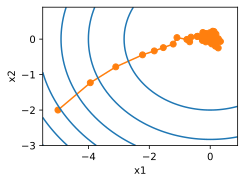

In [4]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

正如我们所见，随机梯度下降中变量的轨迹比我们在:numref:`sec_gd`中观察到的梯度下降要嘈杂得多。这是由于梯度的随机性。也就是说，即使当我们接近最小值时，仍然会受到通过$\eta \nabla f_i(\mathbf{x})$注入的瞬时梯度带来的不确定性的影响。即使在50步之后，质量仍然不是很好。更糟糕的是，再增加步数也不会改善（我们鼓励你用更大的步数来验证这一点）。这使我们只剩下唯一的选择：改变学习率$\eta$。然而，如果我们选择的学习率太小，最初就不会取得任何有意义的进展。另一方面，如果选得太大，如上所述，我们将无法得到一个好的解决方案。解决这些冲突目标的唯一方法是在优化过程中动态地降低学习率。

这也是将学习率函数`lr`添加到`sgd`步骤函数中的原因。在上面的例子中，由于我们将相关的`lr`函数设置为常数，因此任何学习率调度功能都处于休眠状态。

## 动态学习率

用时间依赖的学习率$\eta(t)$代替$\eta$增加了控制优化算法收敛的复杂性。特别是，我们需要弄清楚$\eta$应该以多快的速度衰减。如果太快，我们会过早停止优化。如果速度太慢，我们就会浪费太多的时间在优化上。以下是几种用于随时间调整$\eta$的基本策略（我们稍后将讨论更高级的策略）：

$$
\begin{aligned}
    \eta(t) & = \eta_i \textrm{ if } t_i \leq t \leq t_{i+1}  && \textrm{分段常数} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \textrm{指数衰减} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \textrm{多项式衰减}
\end{aligned}
$$

在第一个*分段常数*的情况下，例如当优化停滞不前时，我们会减少学习率。这是训练深层网络的一种常见策略。或者，我们可以通过*指数衰减*更加积极地减少它。不幸的是，这往往会导致算法在收敛之前过早停止。一个流行的选择是带有$\alpha = 0.5$的*多项式衰减*。对于凸优化而言，有许多证明表明这种速率表现良好。

让我们看看实践中指数衰减的样子。

epoch 1000, x1: -0.758829, x2: -0.115584


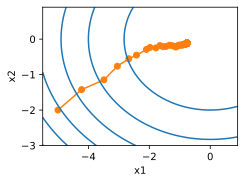

In [5]:
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

正如预期的那样，参数的方差显著减小。然而，这是以未能收敛到最优解 $\mathbf{x} = (0, 0)$ 为代价的。即使经过1000次迭代步骤，我们仍然离最优解很远。实际上，算法根本无法收敛。另一方面，如果我们使用多项式衰减，即学习率随步数的平方根倒数衰减，那么仅在50步后收敛情况就会有所改善。

epoch 50, x1: 0.144834, x2: 0.041688


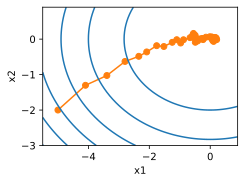

In [6]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

存在许多设置学习率的方法。例如，我们可以从一个较小的学习率开始，然后迅速增加，再缓慢减少。我们甚至可以在较小和较大的学习率之间交替。这样的调度方式有很多种。现在让我们专注于那些可以进行全面理论分析的学习率调度，即凸环境下的学习率。对于一般的非凸问题，要获得有意义的收敛保证是非常困难的，因为一般来说，最小化非线性非凸问题是NP难问题。关于这方面的综述，可以参考Tibshirani 2015年优秀的[讲义](https://www.stat.cmu.edu/%7Eryantibs/convexopt-F15/lectures/26-nonconvex.pdf)。



## 凸目标函数的收敛分析

以下对凸目标函数随机梯度下降的收敛分析是可选的，主要目的是为了传达更多关于问题的直觉。我们将自己限制在最简单的证明之一 :cite:`Nesterov.Vial.2000`。更高级的证明技术也存在，比如当目标函数特别良好时。

假设目标函数$f(\boldsymbol{\xi}, \mathbf{x})$对于所有$\boldsymbol{\xi}$在$\mathbf{x}$上是凸的。
更具体地说，
我们考虑随机梯度下降更新：

$$\mathbf{x}_{t+1} = \mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}),$$

其中$f(\boldsymbol{\xi}_t, \mathbf{x})$
是在步骤$t$从某个分布中抽取的训练样本$\boldsymbol{\xi}_t$处的目标函数，而$\mathbf{x}$是模型参数。
记为

$$R(\mathbf{x}) = E_{\boldsymbol{\xi}}[f(\boldsymbol{\xi}, \mathbf{x})]$$

期望风险以及$R^*$为其关于$\mathbf{x}$的最小值。最后设$\mathbf{x}^*$为最小化器（我们假设它存在于$\mathbf{x}$定义域内）。在这种情况下，我们可以追踪当前参数$\mathbf{x}_t$与风险最小化器$\mathbf{x}^*$之间的距离，并观察其是否随时间改善：

$$\begin{aligned}    &\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 \\ =& \|\mathbf{x}_{t} - \eta_t \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x}) - \mathbf{x}^*\|^2 \\    =& \|\mathbf{x}_{t} - \mathbf{x}^*\|^2 + \eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 - 2 \eta_t    \left\langle \mathbf{x}_t - \mathbf{x}^*, \partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\right\rangle.   \end{aligned}$$
:eqlabel:`eq_sgd-xt+1-xstar`

我们假设随机梯度$\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})$的$\ell_2$范数由某个常数$L$所界，因此我们有

$$\eta_t^2 \|\partial_\mathbf{x} f(\boldsymbol{\xi}_t, \mathbf{x})\|^2 \leq \eta_t^2 L^2.$$
:eqlabel:`eq_sgd-L`


我们主要关心的是$\mathbf{x}_t$和$\mathbf{x}^*$之间距离*在期望*上的变化。实际上，对于任何特定的步骤序列，这个距离可能会根据遇到的$\boldsymbol{\xi}_t$而增加。因此我们需要对点积进行限定。
由于对于任何凸函数$f$来说，对于所有$\mathbf{x}$和$\mathbf{y}$都有
$f(\mathbf{y}) \geq f(\mathbf{x}) + \langle f'(\mathbf{x}), \mathbf{y} - \mathbf{x} \rangle$，
通过凸性我们得到

$$f(\boldsymbol{\xi}_t, \mathbf{x}^*) \geq f(\boldsymbol{\xi}_t, \mathbf{x}_t) + \left\langle \mathbf{x}^* - \mathbf{x}_t, \partial_{\mathbf{x}} f(\boldsymbol{\xi}_t, \mathbf{x}_t) \right\rangle.$$
:eqlabel:`eq_sgd-f-xi-xstar`

将不等式:eqref:`eq_sgd-L` 和 :eqref:`eq_sgd-f-xi-xstar` 插入到:eqref:`eq_sgd-xt+1-xstar` 中，我们可以得到时间$t+1$时参数之间距离的一个界限如下：

$$\|\mathbf{x}_{t} - \mathbf{x}^*\|^2 - \|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2 \geq 2 \eta_t (f(\boldsymbol{\xi}_t, \mathbf{x}_t) - f(\boldsymbol{\xi}_t, \mathbf{x}^*)) - \eta_t^2 L^2.$$
:eqlabel:`eqref_sgd-xt-diff`

这意味着只要当前损失与最优损失之间的差值超过$\eta_t L^2/2$，我们就能取得进展。由于这个差值注定会趋近于零，因此学习率$\eta_t$也需要*消失*。

接下来我们对:eqref:`eqref_sgd-xt-diff`取期望。这样就得到

$$E\left[\|\mathbf{x}_{t} - \mathbf{x}^*\|^2\right] - E\left[\|\mathbf{x}_{t+1} - \mathbf{x}^*\|^2\right] \geq 2 \eta_t [E[R(\mathbf{x}_t)] - R^*] -  \eta_t^2 L^2.$$

最后一步是对$t \in \{1, \ldots, T\}$的不等式求和。由于求和项呈望远镜形式并通过去掉较低项我们得到

$$\|\mathbf{x}_1 - \mathbf{x}^*\|^2 \geq 2 \left (\sum_{t=1}^T   \eta_t \right) [E[R(\mathbf{x}_t)] - R^*] - L^2 \sum_{t=1}^T \eta_t^2.$$
:eqlabel:`eq_sgd-x1-xstar`

注意我们利用了$\mathbf{x}_1$是给定的事实，因此可以去掉期望。最后定义

$$\bar{\mathbf{x}} \stackrel{\textrm{def}}{=} \frac{\sum_{t=1}^T \eta_t \mathbf{x}_t}{\sum_{t=1}^T \eta_t}.$$

由于

$$E\left(\frac{\sum_{t=1}^T \eta_t R(\mathbf{x}_t)}{\sum_{t=1}^T \eta_t}\right) = \frac{\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)]}{\sum_{t=1}^T \eta_t} = E[R(\mathbf{x}_t)],$$

通过Jensen不等式（设定$i=t$，$\alpha_i = \eta_t/\sum_{t=1}^T \eta_t$ 在:eqref:`eq_jensens-inequality`）及$R$的凸性可知$E[R(\mathbf{x}_t)] \geq E[R(\bar{\mathbf{x}})]$，因此

$$\sum_{t=1}^T \eta_t E[R(\mathbf{x}_t)] \geq \sum_{t=1}^T \eta_t  E\left[R(\bar{\mathbf{x}})\right].$$

将此代入不等式:eqref:`eq_sgd-x1-xstar` 得到边界

$$
\left[E[\bar{\mathbf{x}}]\right] - R^* \leq \frac{r^2 + L^2 \sum_{t=1}^T \eta_t^2}{2 \sum_{t=1}^T \eta_t},
$$

其中$r^2 \stackrel{\textrm{def}}{=} \|\mathbf{x}_1 - \mathbf{x}^*\|^2$是初始选择参数与最终结果之间距离的一个界。简而言之，收敛速度取决于如何限制随机梯度的范数($L$)以及初始参数值离最优解有多远($r$)。注意该界是针对$\bar{\mathbf{x}}$而不是$\mathbf{x}_T$给出的。这是因为$\bar{\mathbf{x}}$是优化路径的一种平滑版本。
每当$r, L$和$T$已知时，我们可以选取学习率$\eta = r/(L \sqrt{T})$。这产生了一个上界$rL/\sqrt{T}$。也就是说，我们以$\mathcal{O}(1/\sqrt{T})$的速度收敛到最优解。





## 随机梯度与有限样本

到目前为止，在讨论随机梯度下降时，我们有点儿过于宽松。我们假设我们从某些分布$p(x, y)$中抽取实例$x_i$，通常带有标签$y_i$，并用这些来更新模型参数。特别是对于有限样本大小，我们简单地认为离散分布$p(x, y) = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}(x) \delta_{y_i}(y)$
对于一些函数$\delta_{x_i}$和$\delta_{y_i}$
允许我们在其上执行随机梯度下降。

然而，这并不是我们真正做的。在本节的玩具示例中，我们只是向原本不是随机的梯度添加了噪声，即我们假装拥有成对的数据$(x_i, y_i)$。事实证明这样做在这里是合理的（见练习中的详细讨论）。更令人不安的是，在所有之前的讨论中我们显然没有这么做。相反，我们恰好迭代了一次所有实例。为了理解为什么这样做更好，请考虑相反的情况，即我们从离散分布中*有放回*地抽取$n$个观测值。随机选择元素$i$的概率是$1/n$。因此至少选择一次它的概率是

$$P(\textrm{choose~} i) = 1 - P(\textrm{omit~} i) = 1 - (1-1/n)^n \approx 1-e^{-1} \approx 0.63.$$

类似的推理表明，恰好一次挑选出某个样本（即训练示例）的概率由

$${n \choose 1} \frac{1}{n} \left(1-\frac{1}{n}\right)^{n-1} = \frac{n}{n-1} \left(1-\frac{1}{n}\right)^{n} \approx e^{-1} \approx 0.37.$$

有放回抽样导致方差增加且数据效率降低，相对于无放回抽样而言。因此，在实践中我们执行后者（这也是本书默认的选择）。最后请注意，多次遍历训练数据集会以*不同的*随机顺序遍历它。


## 总结

* 对于凸问题，我们可以证明，对于广泛的学习率选择，随机梯度下降将收敛到最优解。
* 对于深度学习，通常情况并非如此。然而，对凸问题的分析为我们提供了如何处理优化的有用见解，即逐渐降低学习率，但不要过快。
* 当学习率太小或太大时都会出现问题。在实践中，通常只有经过多次实验后才能找到合适的学习率。
* 当训练数据集中有更多的示例时，计算每次迭代的成本更高，因此在这种情况下更倾向于使用随机梯度下降。
* 由于需要检查的局部最小值数量可能呈指数增长，一般情况下无法为非凸情况提供随机梯度下降的最优性保证。




## 练习

1. 尝试不同的学习率计划和不同次数的迭代进行随机梯度下降。特别是，绘制从最优解$(0, 0)$的距离作为迭代次数的函数图。
1. 证明对于函数$f(x_1, x_2) = x_1^2 + 2 x_2^2$向梯度添加正态噪声相当于最小化损失函数$f(\mathbf{x}, \mathbf{w}) = (x_1 - w_1)^2 + 2 (x_2 - w_2)^2$，其中$\mathbf{x}$是从正态分布中抽取的。
1. 比较从$\{(x_1, y_1), \ldots, (x_n, y_n)\}$中有放回采样和无放回采样时随机梯度下降的收敛性。
1. 如果某个梯度（或与其相关联的某个坐标）始终大于所有其他梯度，你将如何改变随机梯度下降求解器？
1. 假设$f(x) = x^2 (1 + \sin x)$。$f$有多少个局部极小值？你能修改$f$使得为了最小化它必须评估所有的局部极小值吗？

[讨论](https://discuss.d2l.ai/t/497)